# Préparation du dataset

In [2]:
# Ajouter chemin système pour naviguer d'un dossier à l'autre facilement
import sys
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from packages import fonctions

%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
########## Import données csv ##########
# dossier data hors du dossier code pour ne pas l'importer dans github

df = pd.read_csv('../../data/flipkart_com-ecommerce_sample_1050.csv')
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [6]:
# Dictionnaire des catégories (pour réduire le nombre de catégories - cf notebook Data_exploration_EDA)
dict_categories = {
    'Home and Kitchen Essential' : [
        'Home Furnishing', 'Tray Sets', 'Coffee Mugs', 'Lunch Boxes', 'Caffeine Bowls', 'Water bottle', 'Omic Sippers', 'Kitchen Tools', 'Bar Accessories', 'Bar Glasses', 'Idli Makers', 'Craft Jugs', 'Table Clocks', 'Bhalaria Forks', 'Kitchen Containers'],
    'Baby and Personal Care' : [
        'Baby Care', 'Personal Care'],
    'Electronics and Accessories' : [
        'Wrist Watches', 'Network Components', 'Tablet Accessories', 'Laptop Accessories', 'Pen Drives', 'Computer Components'],
    'Festive and Special Occasion' : ['Festive Needs', 'BFT Bulbs']
}

In [7]:
# Extraire catégories de la feature 'product_category_tree' et réduire nombre de catégories en utilisant le dictionnaire ci dessus
df['category'] = df.apply(fonctions.get_category, axis = 1)
inverse = { v: k for k, l in dict_categories.items() for v in l }
df['category_4'] = df['category'].map(inverse)
df['category_4'].value_counts()

category_4
Baby and Personal Care          300
Electronics and Accessories     292
Home and Kitchen Essential      263
Festive and Special Occasion    151
Name: count, dtype: int64

In [8]:
df = df[['category_4', 'description']]
df.columns = ['category', 'description']
df.shape

(1050, 2)

In [11]:
df['category'].unique().tolist()

['Home and Kitchen Essential',
 'Baby and Personal Care',
 'Electronics and Accessories',
 'Festive and Special Occasion',
 nan]

In [17]:
from sklearn import preprocessing

path = "../../data/Images/"

list_labels = df['category'].unique().tolist()

data_path = glob(path + '**.jp*')

def data_fct(path) :
    list_photos = [file for file in path]
    print(len(list_photos))
    data = pd.DataFrame()
    data['image_path'] = list_photos
    data['label_name'] = df['category']
    return data

data = data_fct(data_path)[:700]
data_test = data_fct(data_path)[700:]

le = preprocessing.LabelEncoder()
le.fit(data['label_name'])
data['label'] = le.transform(data['label_name'])
data_test['label'] = le.transform(data_test['label_name'])
# data.head(5)
data_test.head(5)

1050
1050


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

,image_path,label_name,label
700,../../data/Images/6c53dbd7a9d43744920bfae3bc06...,Home and Kitchen Essential,3
701,../../data/Images/672d1c3272eae4586eb5994fe408...,Home and Kitchen Essential,3
702,../../data/Images/72db37ec42ee76d79cf395221e0f...,Festive and Special Occasion,2
703,../../data/Images/0ae859a69c7608d8197c3ba8c37b...,Home and Kitchen Essential,3
704,../../data/Images/66b75f053cb7626f49f1a9bffe77...,Home and Kitchen Essential,3


In [18]:
data.groupby("label").count()

,image_path,label_name
label,,
0,197,197
1,219,219
2,102,102
3,140,140
4,42,0


Home and Kitchen Essential


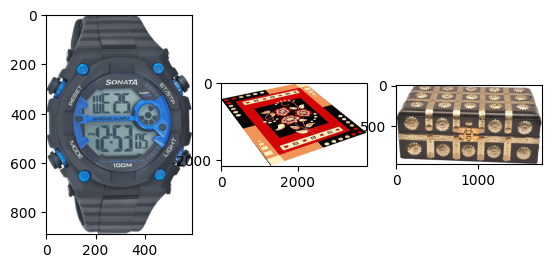

Baby and Personal Care


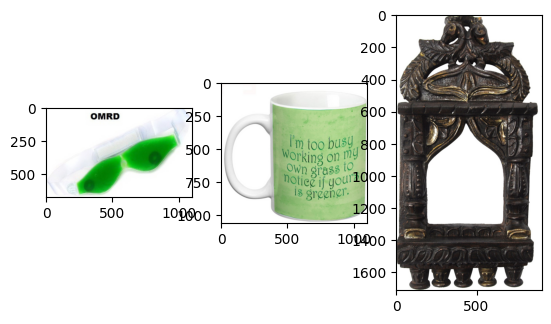

Electronics and Accessories


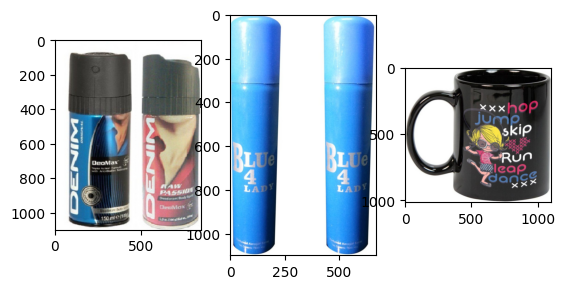

Festive and Special Occasion


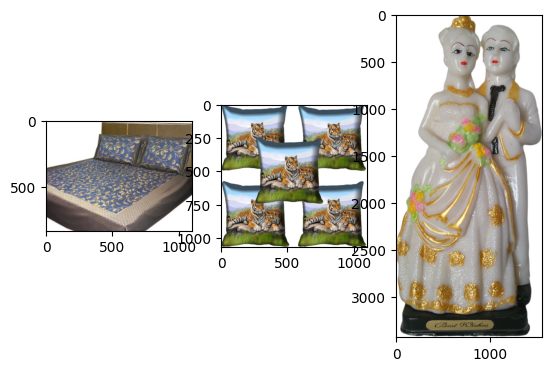

nan


IndexError: list index out of range

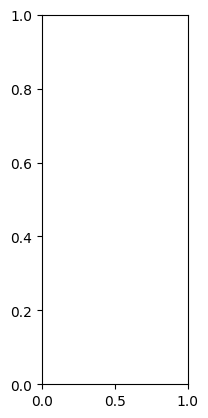

In [21]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [data["image_path"][i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name

list_cloudy=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="Home and Kitchen Essential"]
list_rain=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="Baby and Personal Care"]
list_shine=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="Electronics and Accessories"]
list_sunrise=[data["image_path"][i] for i in range(len(data)) if data["label_name"][i]=="Festive and Special Occasion"]

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# Etape 1 : étude de faisabilité

## Création du modèle pré-entraîné

In [22]:
base_model = VGG16()
model = Model(inputs = base_model.inputs, outputs = base_model.layers[-2].output)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Création des features des images

In [23]:
images_features = []
i = 0 
for image_file in data['image_path']:
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size = (224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis = 0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose = 0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200


/opt/homebrew/lib/python3.11/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


300
400
500
600


(700, 4096)

## Réduction dimension et analyse

### Réduction de dimension PCA

In [24]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components = 0.99)
feat_pca = pca.fit_transform(images_features)
print(feat_pca.shape)

(700, 4096)
(700, 569)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [25]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components = 2, perplexity = 30, n_iter = 2000, init = 'random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             2.99 secondes


/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

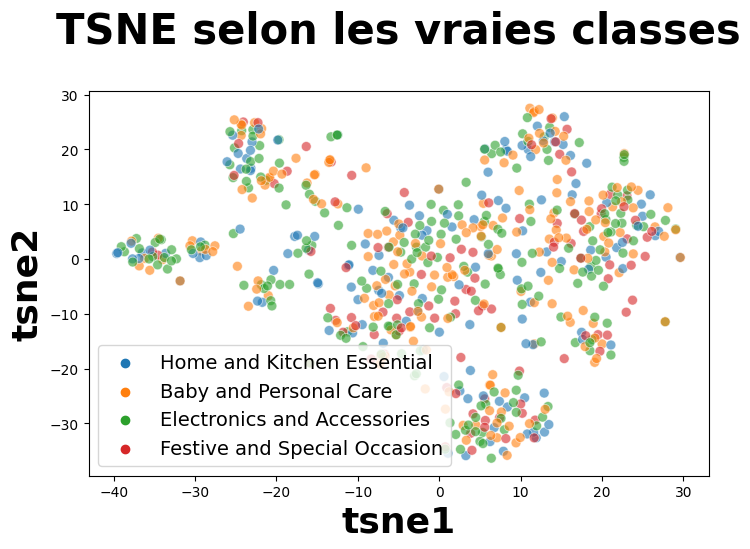

In [26]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement


In [27]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=4, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=4, n_init=100)

/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

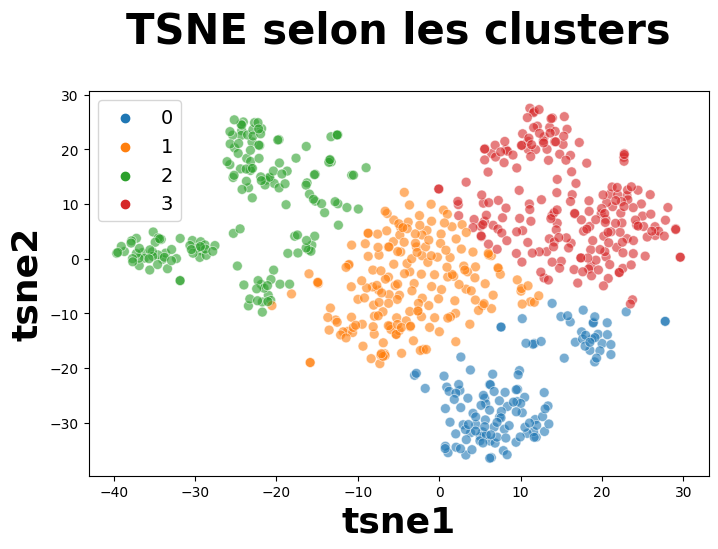

ARI :  0.0012299876760088289


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [28]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [32]:
# Analyse d'image "shine" affectées au cluster 3 "cloudy"

list_shine_0 = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='Baby and Personal Care') and (df_tsne.iloc[i]['cluster']==3)]
list_shine_0[0]

1

tsne1                   12.304711
tsne2                    1.255093
class      Baby and Personal Care
cluster                         3
Name: 220, dtype: object


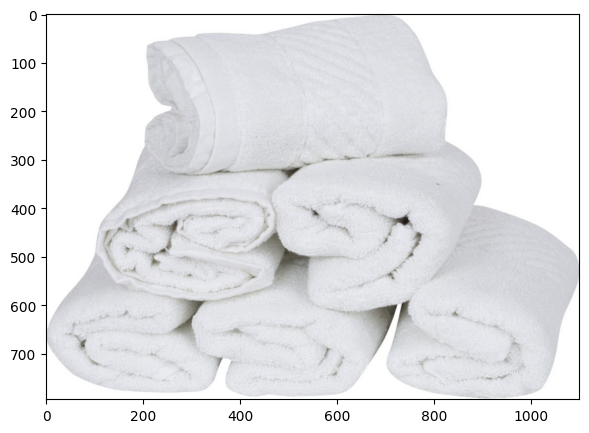

In [31]:
# Affichage image "shine" considérée comme "cloudy"
id = 220 ### A VERIFIER
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (8, 5))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()



* Analyse : le modèle pré-entraîné confond "cloud" avec de la neige ...

### Analyse par classes

In [34]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[34 54 44 65  0]
 [38 58 60 63  0]
 [23 36 13 30  0]
 [25 37 35 43  0]
 [11  8 13 10  0]]


/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

In [35]:
def conf_mat_transform(y_true, y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [36]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [1 1 1 0 0]
[[ 65 132   0   0   0]
 [ 63 156   0   0   0]
 [ 30  72   0   0   0]
 [ 43  97   0   0   0]
 [ 10  32   0   0   0]]

              precision    recall  f1-score   support

           0       0.31      0.33      0.32       197
           1       0.32      0.71      0.44       219
           2       0.00      0.00      0.00       102
           3       0.00      0.00      0.00       140
           4       0.00      0.00      0.00        42

    accuracy                           0.32       700
   macro avg       0.13      0.21      0.15       700
weighted avg       0.19      0.32      0.23       700



/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_d

<Axes: >

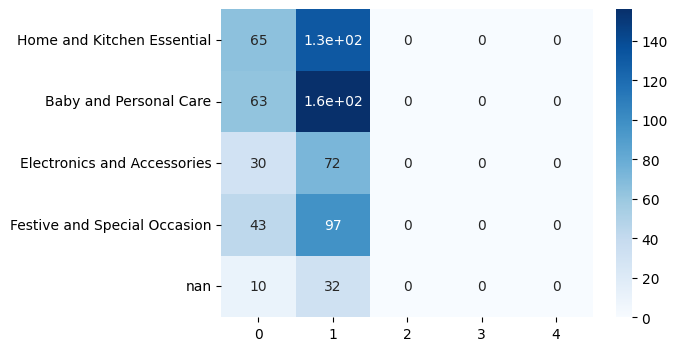

In [38]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "01234"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

* La classe la moins bien prédite est "shine" (CF exemple ci-dessus : confond la neige avec un nuage)

# Etape 2 : classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

In [101]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top = False, weights = "imagenet", input_shape = (224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(5, activation = 'softmax')(x) # 5 = nb de catégories

    # Définir le nouveau modèle
    model = Model(inputs = model0.input, outputs = predictions)
    # compilation du modèle 
    model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ["accuracy"]) # optimizer = 'rmsprop'

    print(model.summary())

    return model


In [102]:
# labels = 

## Approche préparation initiale des images

In [103]:
def image_prep_fct(data):
    prepared_images = []
    for image_num in range(len(data['image_path'])):
        img = (load_img(data['image_path'][image_num], target_size = (224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

In [104]:
images_np = image_prep_fct(data)
print(images_np.shape)

/opt/homebrew/lib/python3.11/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(700, 224, 224, 3)


In [105]:
data_test.reset_index(drop = True, inplace = True)

In [106]:
data_test

,image_path,label_name,label
0,../../data/Images/6c53dbd7a9d43744920bfae3bc06...,Home and Kitchen Essential,3
1,../../data/Images/672d1c3272eae4586eb5994fe408...,Home and Kitchen Essential,3
2,../../data/Images/72db37ec42ee76d79cf395221e0f...,Festive and Special Occasion,2
3,../../data/Images/0ae859a69c7608d8197c3ba8c37b...,Home and Kitchen Essential,3
4,../../data/Images/66b75f053cb7626f49f1a9bffe77...,Home and Kitchen Essential,3
...,...,...,...
345,../../data/Images/4e5ebfc871992e7e22365c0c036a...,Baby and Personal Care,0
346,../../data/Images/82fbc93cd45ab747e7e606f2c52c...,Baby and Personal Care,0
347,../../data/Images/216c6c3527984be3d7ad9023d5cd...,Baby and Personal Care,0
348,../../data/Images/f54d0c5cbd8e2270742293edf907...,Baby and Personal Care,0


In [107]:
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

(350, 224, 224, 3)


In [108]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [109]:
y_test

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [110]:
X

array([[[[  95.061    ,   79.221    ,   68.32     ],
         [  93.061    ,   76.221    ,   68.32     ],
         [  95.061    ,   77.221    ,   71.32     ],
         ...,
         [  71.061    ,   62.221    ,   56.32     ],
         [  69.061    ,   60.221    ,   54.32     ],
         [  66.061    ,   57.221    ,   51.32     ]],

        [[  93.061    ,   77.221    ,   66.32     ],
         [  93.061    ,   76.221    ,   68.32     ],
         [  96.061    ,   78.221    ,   72.32     ],
         ...,
         [  68.061    ,   59.221    ,   53.32     ],
         [  68.061    ,   59.221    ,   53.32     ],
         [  69.061    ,   60.221    ,   54.32     ]],

        [[  94.061    ,   77.221    ,   69.32     ],
         [  94.061    ,   77.221    ,   69.32     ],
         [  95.061    ,   77.221    ,   71.32     ],
         ...,
         [  70.061    ,   61.221    ,   55.32     ],
         [  67.061    ,   58.221    ,   52.32     ],
         [  64.061    ,   55.221    ,   49.32     ]],

In [111]:
X_test

array([[[[ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         ...,
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ]],

        [[ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         ...,
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ]],

        [[ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         ...,
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ],
         [ 151.061   ,  138.22101 ,  131.32    ]],

        ...,

        [[ 151.061   ,  138.22101 ,  1

In [112]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, test_size = 0.25, random_state = 42)
X_train.shape

(525, 224, 224, 3)

In [113]:
X_test.shape

(350, 224, 224, 3)

In [114]:
# Création du modèle
with tf.device('/gpu:0'):
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = './model1_best_weights.h5'
checkpoint = ModelCheckpoint(model1_save_path1, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
callbacks_list = [checkpoint, es]


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [115]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs = 50, batch_size = 64, callbacks = callbacks_list, validation_data = (X_val, y_val), verbose = 1)


Epoch 1/50
9/9 [==============================] - ETA: 0s - loss: 8.1854 - accuracy: 0.2362
Epoch 1: val_loss improved from inf to 5.35888, saving model to ./model1_best_weights.h5
9/9 [==============================] - 71s 8s/step - loss: 8.1854 - accuracy: 0.2362 - val_loss: 5.3589 - val_accuracy: 0.2400
Epoch 2/50


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - ETA: 0s - loss: 4.8540 - accuracy: 0.3257
Epoch 2: val_loss improved from 5.35888 to 3.59840, saving model to ./model1_best_weights.h5
9/9 [==============================] - 73s 8s/step - loss: 4.8540 - accuracy: 0.3257 - val_loss: 3.5984 - val_accuracy: 0.2171
Epoch 3/50
9/9 [==============================] - ETA: 0s - loss: 3.3518 - accuracy: 0.3276
Epoch 3: val_loss improved from 3.59840 to 3.38382, saving model to ./model1_best_weights.h5
9/9 [==============================] - 70s 8s/step - loss: 3.3518 - accuracy: 0.3276 - val_loss: 3.3838 - val_accuracy: 0.2343
Epoch 4/50
9/9 [==============================] - ETA: 0s - loss: 2.7431 - accuracy: 0.4019
Epoch 4: val_loss improved from 3.38382 to 3.14501, saving model to ./model1_best_weights.h5
9/9 [==============================] - 68s 8s/step - loss: 2.7431 - accuracy: 0.4019 - val_loss: 3.1450 - val_accuracy: 0.2229
Epoch 5/50
9/9 [==============================] - ETA: 0s - loss: 2.0324 - 

In [ ]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose = True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose = True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose = False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose = False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path = "standard.png")
plt.close()

In [ ]:
y_val_num = np.argmax(y_val, axis = 1)
y_val_pred = np.argmax(model1.predict(X_val), axis = 1)
y_val_num = np.argmax(y_val, axis = 1)
print(y_val_num)
print()
print(y_val_pred)

In [ ]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

In [ ]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot = True, cmap = "Blues")

* Les images "shine" contenant de la neige sont désormais bien affectées à "shine" et non pas "cloud"

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [ ]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
with tf.device('/gpu:0'): 
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


In [ ]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [ ]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


In [ ]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [ ]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

In [ ]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label



In [ ]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(4, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


In [ ]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()